In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.interpolate import interp2d

try:  # if running with Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    import sys
    # the location where you saved the tools.py and csv files
    drive_dir = '/content/drive/My Drive/Colab Notebooks/FCTT 3'
    sys.path.insert(0, drive_dir)

    data_dir =os.path.join(drive_dir, 'battery_experimental_data')
except:  # if running locally
    data_dir = os.path.abspath('battery_experimental_data')
    
from tools import *

## Load data

Extract in an array of numpy arrays. Now we add one more dimension, where the first dimension represents the temperature, i.e., [3, N].

For t, I and V_actual for each temperature, pad them with constant values to the same length so that they can be saved as arrays, which is easier for later calculation.

In [2]:
SOC_OCV_data = pd.read_csv(os.path.join(data_dir, 'SOC_OCV_MFCTT_2019.csv'), sep='\t')
training_data_0 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_0.csv'))
training_data_20 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_20.csv'))
training_data_40 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_40.csv'))

In [3]:
ref_SOC = SOC_OCV_data['SOC'].values                   # unit in %
ref_OCV = SOC_OCV_data['Ecell/V'].values               # unit in V
SOC_levels = np.arange(0.9, 0.1, -0.1)
SOC_from_idx_map = {i: SOC_levels[i] for i in range(8)}  # 8 SOC levels
temp_from_idx_map = {0: '$0^oC$', 1: '$20^oC$', 2: '$40^oC$'}  # 3 temperature level


def pad_time(t, max_length):
    N = len(t)
    if N == max_length:
        return t
    interval = t[-1] - t[-2]
    padded_t = np.pad(t, (0, max_length - N), mode='constant', constant_values=(0))
    padded_t[N - max_length:] = np.arange(t[-1] + interval, t[-1] + (max_length-len(t)+1) * interval, interval)
    
    return padded_t

max_length = np.max([len(training_data_0), len(training_data_20), len(training_data_40)])
t = [pad_time(training_data_0['Time (s)'].values, max_length), 
     pad_time(training_data_20['Time (s)'].values, max_length), 
     pad_time(training_data_40['Time (s)'].values, max_length)]
I = [np.pad(training_data_0['Current (A)'], (0, max_length - len(training_data_0)), mode='edge'),
     np.pad(training_data_20['Current (A)'], (0, max_length - len(training_data_20)), mode='edge'),
     np.pad(training_data_40['Current (A)'], (0, max_length - len(training_data_40)), mode='edge')]
V_actual = [np.pad(training_data_0['Voltage (V)'], (0, max_length - len(training_data_0)), mode='edge'),
            np.pad(training_data_20['Voltage (V)'], (0, max_length - len(training_data_20)), mode='edge'),
            np.pad(training_data_40['Voltage (V)'], (0, max_length - len(training_data_40)), mode='edge')]
t = np.array(t)                            # unit in s
I = -np.array(I)                           # unit in A
V_actual = np.array(V_actual)              # unit in V

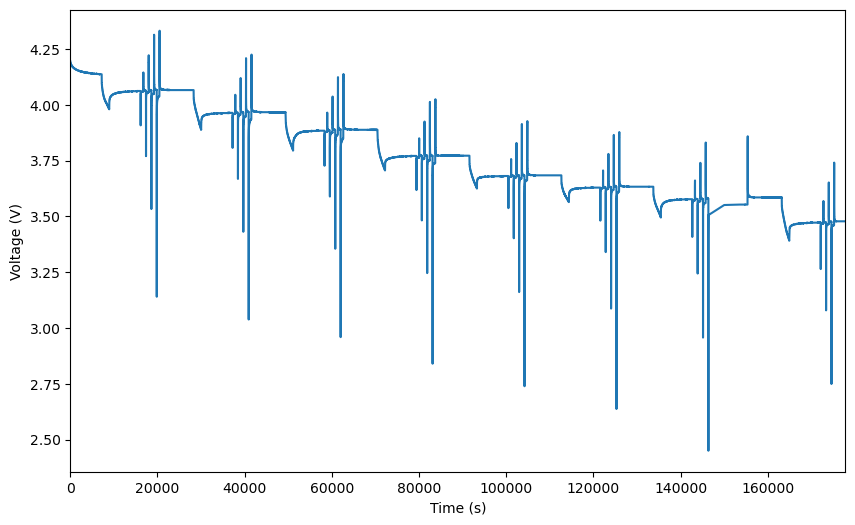

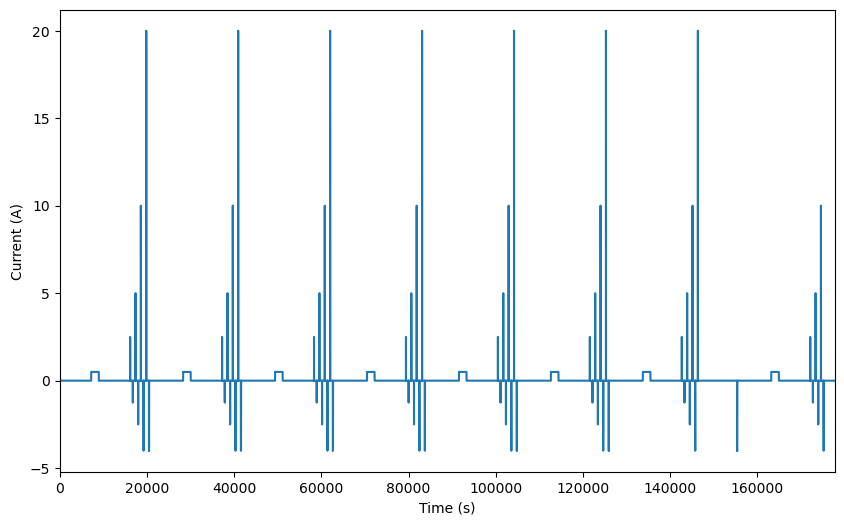

In [4]:
which_temp = 0  # 0 if 0 degC, 1 if 20 degC, 2 if 40 degC
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t[which_temp], V_actual[which_temp])
ax.set_xlim([0, t[which_temp, -1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')

_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t[which_temp], I[which_temp])
ax.set_xlim([0, t[which_temp, -1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (A)')

plt.show()

## Splitting Pulses

The idx arrays now have shapes of [3, 8, 8], i.e., [temperatures, SOCs, Current]

In [5]:
idx_pulse_start = np.ndarray((3, 8, 8), dtype='int')
idx_pulse_end = np.ndarray((3, 8, 8), dtype='int')

for i in range(3):
    # shift to left by one index (now i is equivalent to i+1)
    I_shifted = np.concatenate((I[i, 1:], [0]))
    idx_start = np.flatnonzero((I[i] == 0) & (np.abs(I_shifted) > 1))
    idx_end = np.flatnonzero((np.abs(I[i]) > 1) & (I_shifted == 0)) + 1
    
    # if there are less than 8*8=64 points, pad with the last value to size 64
    # (because 0 deg has only 6 pulses at the last SOC)
    idx_start = np.pad(idx_start, (0, 64 - len(idx_start)), mode='edge')
    idx_end = np.pad(idx_end, (0, 64 - len(idx_end)), mode='edge')

    # reshape to 8 x 8 matrix, where rows correspond to each SOC value and
    #                                cols correspond to each pulse with different current
    idx_pulse_start[i] = idx_start.reshape(8, 8)
    idx_pulse_end[i] = idx_end.reshape(8, 8)

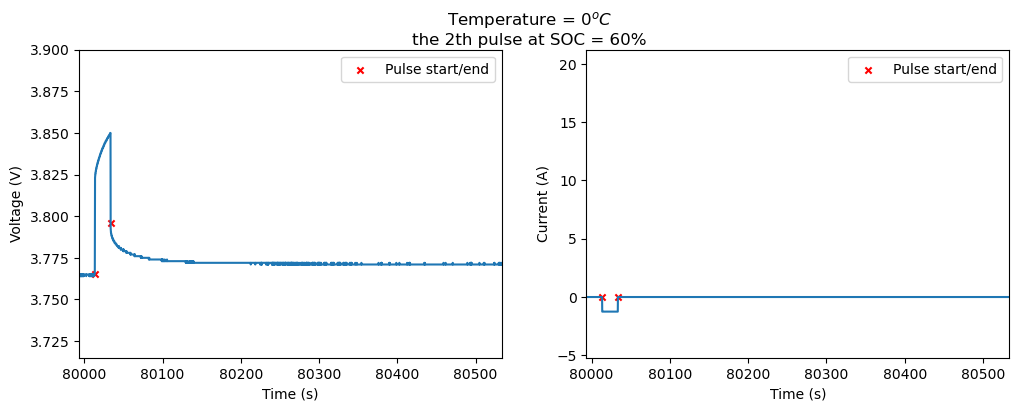

In [8]:
which_temp = 0
which_SOC = 4
which_pulse = 2
plot_pulses(t, I, V_actual, idx_pulse_start, idx_pulse_end,
            which_SOC, which_pulse, show_current=True, temperature=which_temp)

Find index of steady-state voltage for each pulse:

In [9]:
idx_Vss = np.ndarray((3, 8, 8), dtype='int')
for j in range(3):
    idx_each_temp = []
    all_ends = idx_pulse_end[j].flatten()
    for pos in range(len(all_ends)):
        i = 0
        while True:
            # if observing num_criteria of constant values, steady state is reached
            num_criteria = 500
            segment = V_actual[j][all_ends[pos]+i : all_ends[pos]+i+num_criteria] 
            if np.all(segment == segment[0]):  # all element in this array are the same
                idx_each_temp.append(all_ends[pos]+i)
                break
            i += 1

            # Stop browsing if touching the next next pulse, or the end
            i_limit = np.concatenate((idx_pulse_start[j].flatten()[1:], [t.shape[1]]))
            if i > i_limit[pos]:
                which_SOC = pos//8
                SOC_level = SOC_from_idx_map[which_SOC]
                msg = "Position of V_ss is not found for the {}th pulse at SOC = {:0.0f}%".format(pos%8, SOC_level*100)
                raise ValueError(msg)

    idx_Vss[j] = np.reshape(idx_each_temp, [8, 8])

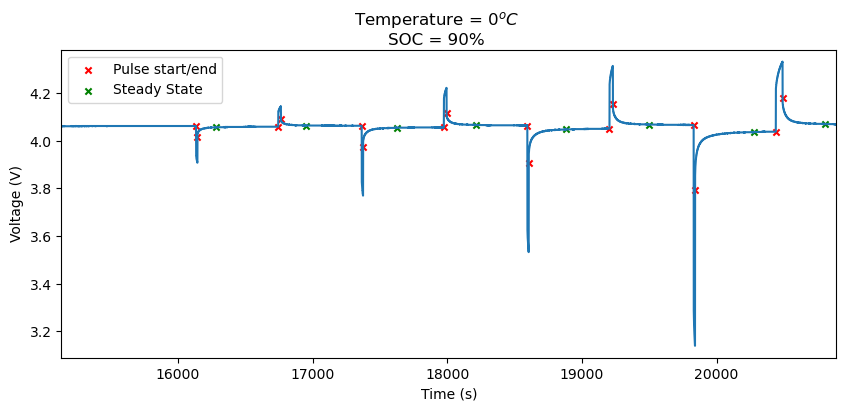

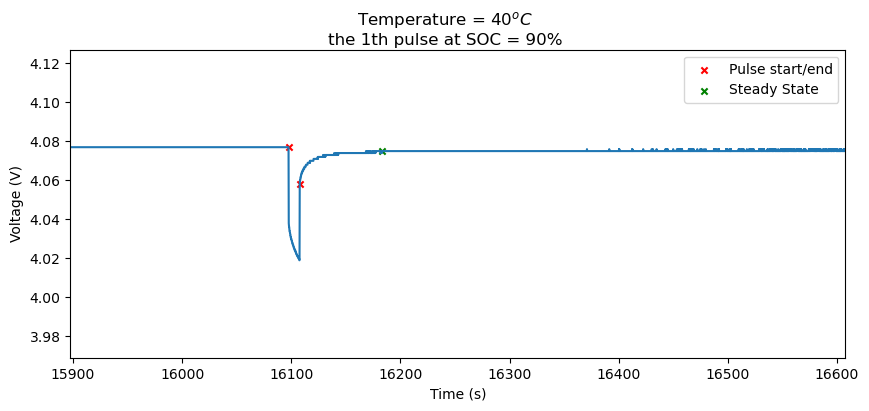

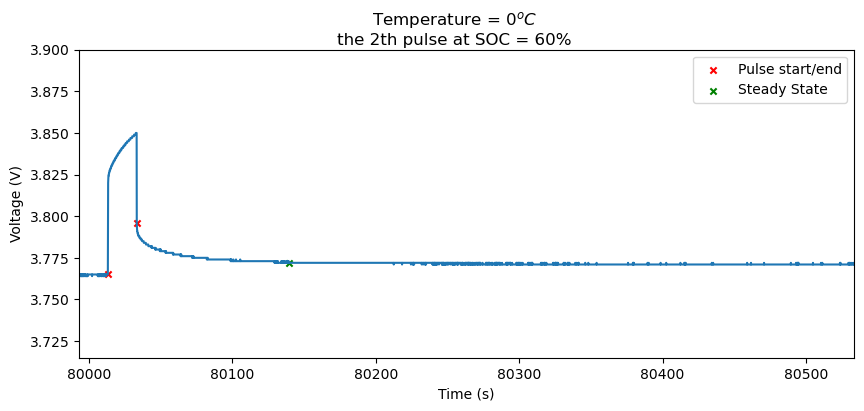

In [11]:
which_temp = 0
which_SOC = 1
which_pulse = 'all'
plot_pulses(t, I, V_actual, idx_pulse_start, idx_pulse_end,
            which_SOC, which_pulse, idx_Vss, show_current=False, temperature=which_temp)

which_temp = 2
which_SOC = 1
which_pulse = 1
plot_pulses(t, I, V_actual, idx_pulse_start, idx_pulse_end,
            which_SOC, which_pulse, idx_Vss, show_current=False, temperature=which_temp)

which_temp = 0
which_SOC = 4
which_pulse = 2
plot_pulses(t, I, V_actual, idx_pulse_start, idx_pulse_end,
            which_SOC, which_pulse, idx_Vss, show_current=False, temperature=which_temp)

## Parametrisation

In [12]:
def index_3D(array, idx):
    res = [np.reshape(array[i][idx.reshape(3, -1)[i]], [8, 8]) for i in range(3)]

    return np.array(res)

In [13]:
V_peaks = index_3D(V_actual, idx_pulse_end - 1)
I_peaks = index_3D(I, idx_pulse_end - 1)

V_pulse_end = index_3D(V_actual, idx_pulse_end)
d_V0 = V_pulse_end - V_peaks
I_pulse_end = index_3D(I, idx_pulse_end)
d_I = I_pulse_end - I_peaks
R0_tab = np.abs(d_V0 / d_I)  # look-up table

V_Vss = index_3D(V_actual, idx_Vss)
d_Vinf = V_Vss - V_peaks
R1_tab = np.abs(d_Vinf / d_I - R0_tab)

t_Vss = index_3D(t, idx_Vss)
t_pulse_end = index_3D(t, idx_pulse_end)
C1_tab = np.abs((t_Vss - t_pulse_end) / (4*R1_tab))
C1_const = 197.27991163742004  # from part 2a

# C1_tab = np.abs((t[idx_Vss] - t[idx_pulse_end]) / (4*R1_tab))
# Visualisation:
rows = pd.MultiIndex.from_product([['%d%%' % (SOC_from_idx_map[i]*100) for i in range(8)],
                                   np.arange(1, 9)],
                                   names=['SOC', 'Pulse'])

# df0 = pd.DataFrame({'$R_0$ $(\Omega)$': R0_tab[0].flatten(),
#                     '$R_1$ $(\Omega)$': R1_tab[0].flatten(),
#                     '$C_1$ $(F)$': C1_const}, index=rows)
# df0.iloc[-2:] = np.nan  # only 6 pulses here

# df20 = pd.DataFrame({'$R_0$ $(\Omega)$': R0_tab[1].flatten(),
#                      '$R_1$ $(\Omega)$': R1_tab[1].flatten(),
#                      '$C_1$ $(F)$': C1_const}, index=rows)

# df40 = pd.DataFrame({'$R_0$ $(\Omega)$': R0_tab[2].flatten(),
#                      '$R_1$ $(\Omega)$': R1_tab[2].flatten(),
#                      '$C_1$ $(F)$': C1_const}, index=rows)

df0 = pd.DataFrame({'$R_0$ $(\Omega)$': R0_tab[0].flatten(),
                    '$R_1$ $(\Omega)$': R1_tab[0].flatten(),
                    '$C_1$ $(F)$': C1_tab[0].flatten()}, index=rows)
df0.iloc[-2:] = np.nan  # only 6 pulses here

df20 = pd.DataFrame({'$R_0$ $(\Omega)$': R0_tab[1].flatten(),
                     '$R_1$ $(\Omega)$': R1_tab[1].flatten(),
                     '$C_1$ $(F)$': C1_tab[1].flatten()}, index=rows)

df40 = pd.DataFrame({'$R_0$ $(\Omega)$': R0_tab[2].flatten(),
                     '$R_1$ $(\Omega)$': R1_tab[2].flatten(),
                     '$C_1$ $(F)$': C1_tab[2].flatten()}, index=rows)

# For display:
table1 = df0.to_html()
table2 = df20.to_html()
table3 = df40.to_html()

# Concatenate the HTML tables horizontally
html = '<table style="display:inline-block;"><tr><th>T = 0 degC</th></tr><tr><td>{0}</td></tr></table>'.format(table1)
html += '<table style="display:inline-block;"><tr><th>T = 20 degC</th></tr><tr><td>{0}</td></tr></table>'.format(table2)
html += '<table style="display:inline-block;"><tr><th>T = 40 degC</th></tr><tr><td>{0}</td></tr></table>'.format(table3)
display(HTML(html))